In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

# Data loading

In [2]:
path_to_data = '../datasets/raw/data/'

In [3]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))



# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]

list_of_df = [df.drop(columns=['changepoint']) for df in list_of_df]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

In [4]:
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 9)
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly
datetime,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0


# Data visualization

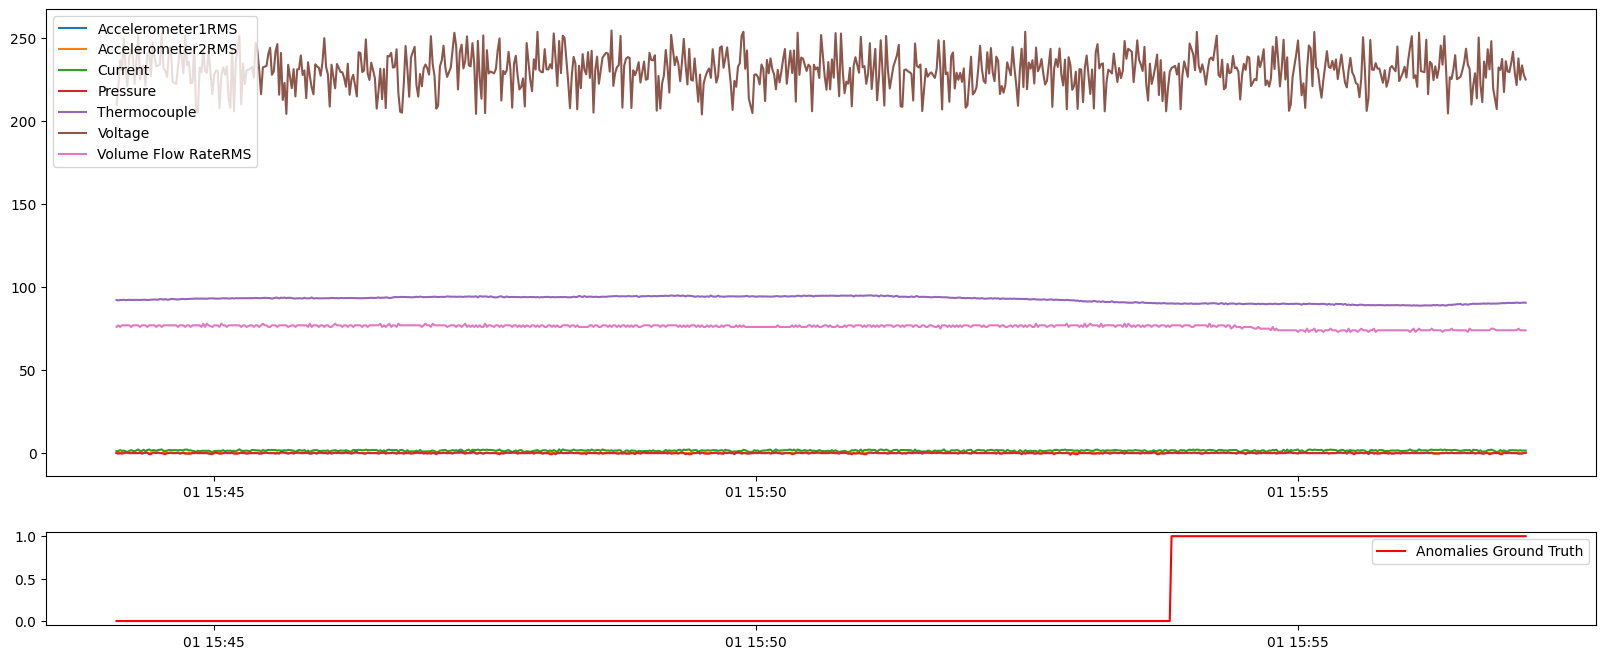

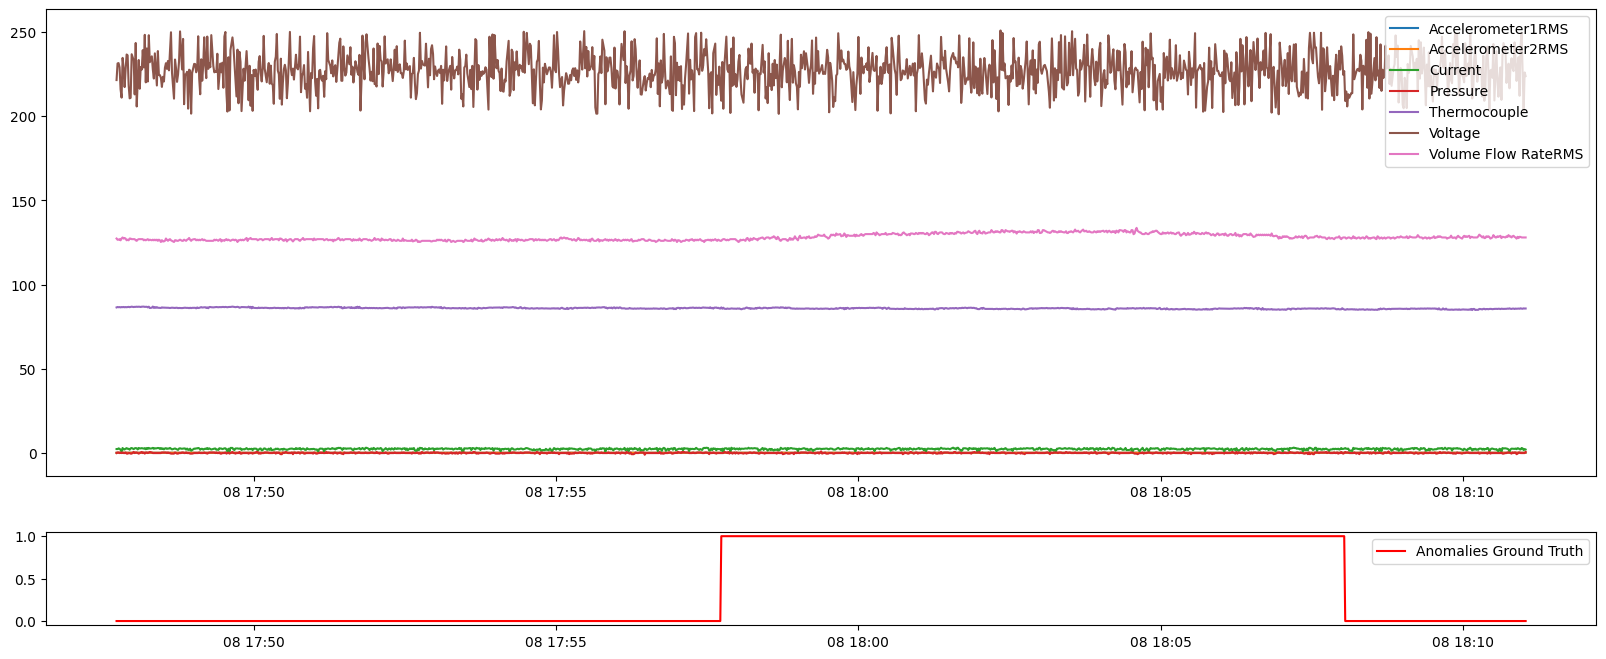

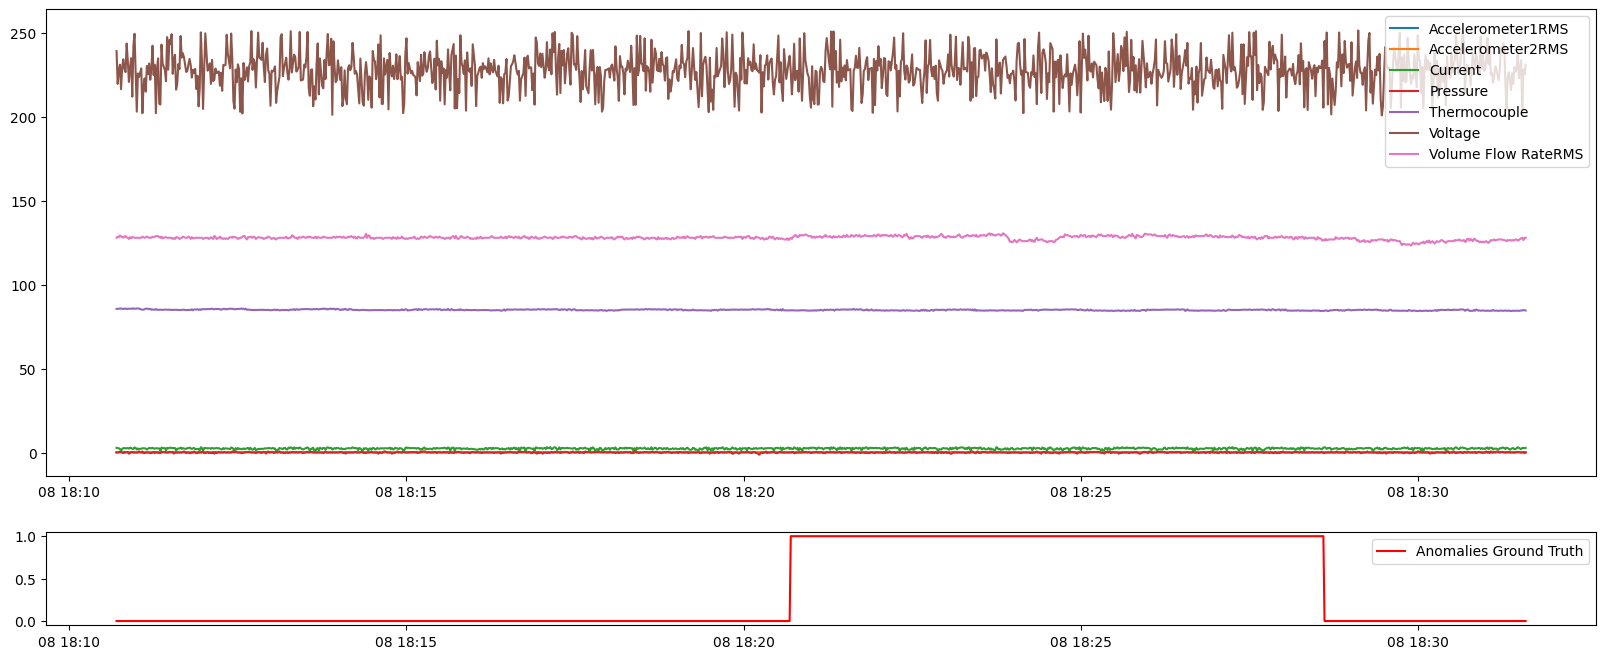

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_skab(data, true_anomalies, detected_anomalies=None):
    if detected_anomalies is None:
        f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, figsize=(20,8))
        a0.plot(data['Accelerometer1RMS'], label='Accelerometer1RMS')
        a0.plot(data['Accelerometer2RMS'], label='Accelerometer2RMS')
        a0.plot(data['Current'], label='Current')
        a0.plot(data['Pressure'], label='Pressure')
        a0.plot(data['Temperature'], label='Thermocouple')
        a0.plot(data['Voltage'], label='Voltage')
        a0.plot(data['Volume Flow RateRMS'], label='Volume Flow RateRMS')
        a0.legend()
        a1.plot(true_anomalies, 'r', label='Anomalies Ground Truth')
        a1.legend()
        plt.show()
    else:
        f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [5, 1, 1]}, figsize=(20,8))
        a0.plot(data['Accelerometer1RMS'], label='Accelerometer1RMS')
        a0.plot(data['Accelerometer2RMS'], label='Accelerometer2RMS')
        a0.plot(data['Current'], label='Current')
        a0.plot(data['Pressure'], label='Pressure')
        a0.plot(data['Temperature'], label='Thermocouple')
        a0.plot(data['Voltage'], label='Voltage')
        a0.plot(data['Volume Flow RateRMS'], label='Volume Flow RateRMS')
        a0.legend()
        a1.plot(true_anomalies, 'r', label='Ground Truth Anomalies')
        a1.legend()
        a2.plot(detected_anomalies, 'r', label='Predicted Anomalies')
        a2.legend()
        plt.show()

plot_skab(list_of_df[0].drop(columns=['anomaly']), list_of_df[0].anomaly)

plot_skab(list_of_df[1].drop(columns=['anomaly']), list_of_df[1].anomaly)

plot_skab(list_of_df[2].drop(columns=['anomaly']), list_of_df[2].anomaly)

# Anomaly detection

In [74]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class ConvAE(tf.keras.Model):
    def __init__(self, input_shape, net_layers, padding, activation, optimizer, loss):
        super().__init__()
        encoder_layers = []
        decoder_layers = []

        encoder_layers.append(layers.Input(shape=input_shape))
        for i in range(0, len(net_layers)):
            encoder_layers.append(layers.Conv1D(filters=net_layers[i][0], kernel_size=net_layers[i][1], padding=padding, strides=net_layers[i][2], activation=activation))

        for i in range(len(net_layers)-2, -1, -1):
            decoder_layers.append(layers.Conv1DTranspose(filters=net_layers[i][0], kernel_size=net_layers[i][1], padding=padding, strides=net_layers[i][2], activation=activation))
        decoder_layers.append(layers.Conv1DTranspose(filters=input_shape[1], kernel_size=net_layers[-1][1], padding=padding))
        
        self.encoder = tf.keras.Sequential(encoder_layers)
        self.decoder = tf.keras.Sequential(decoder_layers)

        self.compile(optimizer=optimizer, loss=loss)

        self.threshold = None
        self.hist = None

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

    def train(self, train_data, epochs=50, batch_size=128):
        hist = self.fit(
            train_data,
            train_data,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=0
            )
        self.hist = {'loss': hist.history['loss'], 'val_loss': hist.history['val_loss']}
        self.set_threshold(train_data)

    def plot_train_history(self):
        plt.plot(self.hist["loss"], label="Training Loss")
        plt.plot(self.hist["val_loss"], label="Validation Loss")
        plt.legend()
        plt.show()

    def set_threshold(self, train_data):
        self.threshold = np.max(self.reconstruction_error(train_data))
        
    def reconstruction_error(self, data):
        pred = keras.losses.mae(self.predict(data), data)
        residual = np.zeros((pred.shape[0]+31))
        for i in range(0, pred.shape[0], 1):
            residual[i:i+32] = np.array([residual[i+j] if pred[i][j] <= residual[i+j] else pred[i][j] for j in range(pred[i].shape[0])])
        return  residual

    def detect_anomalies(self, test_data):
        residual = self.reconstruction_error(test_data)
        return np.array((residual > self.threshold)).astype(int)

In [75]:
N_STEPS = 32

def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [79]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df = list_of_df[0]

scaler = MinMaxScaler()
x = scaler.fit_transform(df[:300].drop(columns=['anomaly']))
X = create_sequences(x)

9/9 [==============================] - 0s 2ms/step


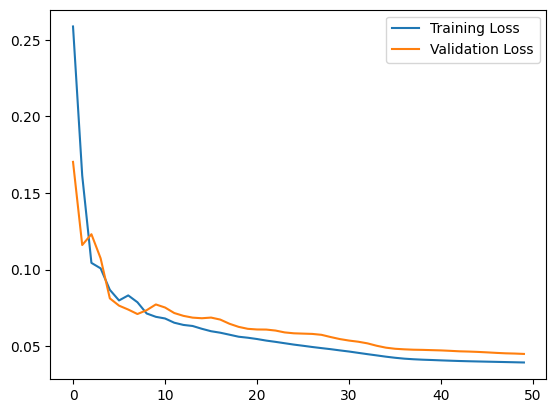

In [80]:
detector = ConvAE(X[0].shape, [(32, 7, 2), (16, 7, 2), (16, 7, 1)], padding='same', activation='elu', optimizer='adam', loss='mse')
detector.train(X, epochs=50)
detector.plot_train_history()

23/23 [==============================] - 0s 2ms/step


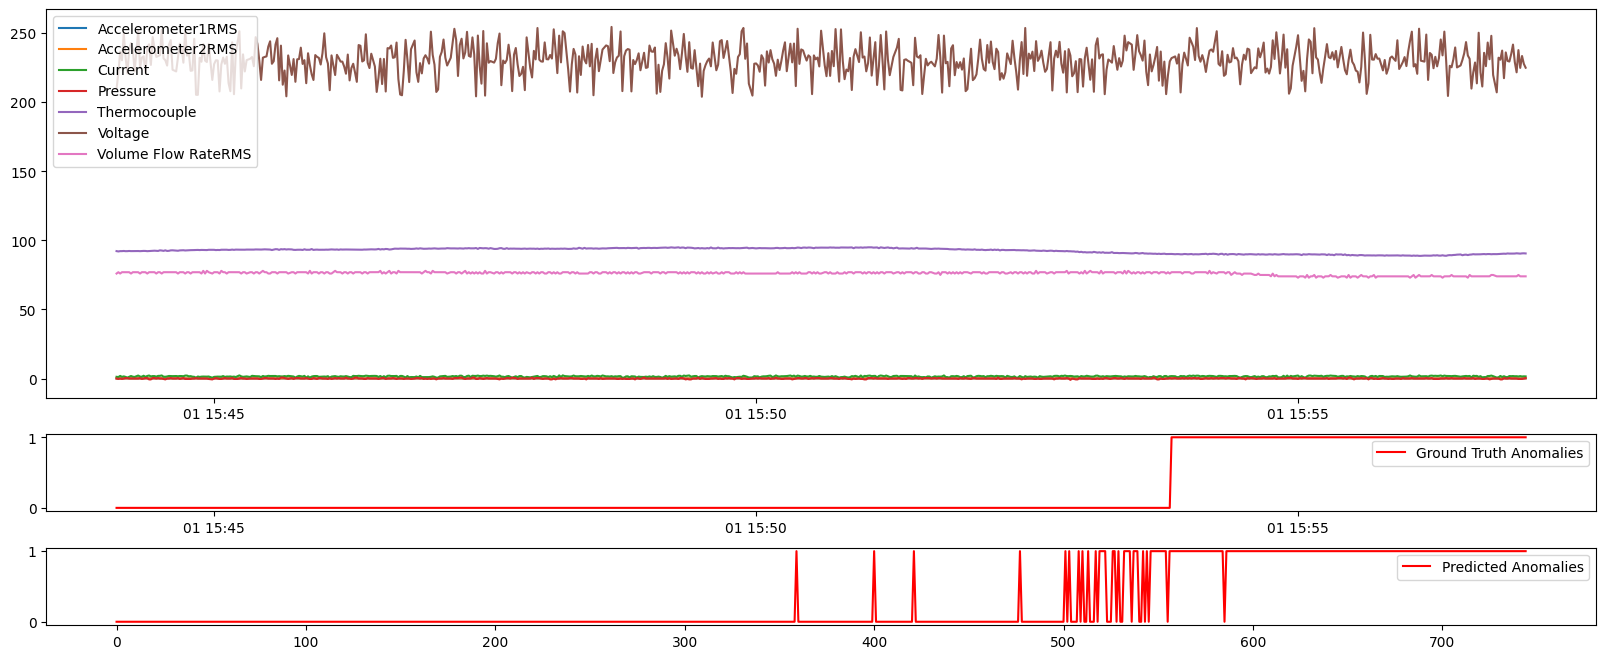

In [81]:
anomalies1 = detector.detect_anomalies(create_sequences(scaler.transform(df.drop(columns=['anomaly']))))

plot_skab(df.drop(columns=['anomaly']), df.anomaly, anomalies1)